# Tidy Data


> Structuring datasets to facilitate analysis ([Wickham 2014](http://www.jstatsoft.org/v59/i10/paper))

Tidy Data (and the closely related topic of reshaping data) is a way of structuring your data and APIs in a consistent way to make the data analysis process flow more smoothly.

## Rules for the impatient


1. Each variable forms a column
2. Each observation forms a row

In my experience, this is the hardest part of teaching pandas (or R / dplyr / the tidyverse). People can pick up syntax, methods, etc. But knowing what shape your data needs to be in to most easily answer your question is harder.

## NBA Games

Earlier, I grabbed some data from www.basketball-reference.com. It's a tad messy

```
Date,Start (ET),Unnamed: 2,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 7,Notes
October,,,,,,,,
"Tue, Oct 27, 2015",8:00 pm,Box Score,Detroit Pistons,106.0,Atlanta Hawks,94.0,,
"Tue, Oct 27, 2015",8:00 pm,Box Score,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,,
"Tue, Oct 27, 2015",10:30 pm,Box Score,New Orleans Pelicans,95.0,Golden State Warriors,111.0,,
```

There's some junk in there (what's this `Unnamed: 2` stuff?), but in the raw data, the fields we care about are something like

date       | visitor team    | visitor points | home team     | home points |
---------- | --------------- | -------------- | ------------- | ----------- |
2015-10-07 | Detroit Pistons | 106            | Atlanta Hawks | 94          |

In [1]:
import pandas as pd

games = pd.read_csv("data/games.csv.gz")
games

,Date,Start (ET),Unnamed: 2,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 7,Notes
0,October,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Tue, Oct 27, 2015",8:00 pm,Box Score,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN
2,"Tue, Oct 27, 2015",8:00 pm,Box Score,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN
3,"Tue, Oct 27, 2015",10:30 pm,Box Score,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN
4,"Wed, Oct 28, 2015",7:30 pm,Box Score,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1232,"Wed, Apr 13, 2016",8:00 pm,Box Score,Indiana Pacers,97.0,Milwaukee Bucks,92.0,NaN,NaN
1233,"Wed, Apr 13, 2016",8:00 pm,Box Score,New Orleans Pelicans,109.0,Minnesota Timberwolves,144.0,NaN,NaN
1234,"Wed, Apr 13, 2016",10:30 pm,Box Score,Los Angeles Clippers,105.0,Phoenix Suns,114.0,NaN,NaN
1235,"Wed, Apr 13, 2016",10:30 pm,Box Score,Denver Nuggets,99.0,Portland Trail Blazers,107.0,NaN,NaN


We have some general cleaning up to do. We'll use a small method chain to handle all that.

In [2]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (
    pd.read_csv("data/games.csv.gz")
      .rename(columns=column_names)
      # Drop "blank" rows with >4 missing values
      .dropna(thresh=4)
      # Select just the columns we'll use
      [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
      # Fix the dtype on the `date` column
      .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
      # Make a multi-level index with (row_number, date) as the index.
      .set_index('date', append=True)
      .rename_axis(["game_id", "date"])
      .sort_index()
)
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0


There's a couple new components in that chain:

1. `DataFrame.rename(columns=dict)` to clean up the names a bit
2. Selecting multiple columns with `[ list_of_columns ]`.
3. `DataFrame.assign` to create a new column from an existing one
4. `set_index` to move a column to the index to be a row label
5. Multi-level row labels. This is like a composite primary key in SQL.


Now onto our question: **How many days of rest did each team have between each game**?

Given that question: is our data tidy?


Or to put it another way: what would a tidy dataset look like? Write down the columns in a tidy dataset for this question.

## Melt

Our dataset is not tidy because we have *multiple observations per row*. Each row in `games` contains an observation for the home team *and* an observation for the away team.

The `melt` method can help you here. 

![](images/melt.png)

You specify

1. `value_vars`: The colums that the observation is currently spread across
2. The `id_vars`: variables that, together with `value_vars` will uniquely identify the result. These are *repeated* as needed to stay with the original observation.
3. The output column names for each of these.

In [3]:
teams = (
    games.reset_index()  # Move row labels to columns. melt works just with columns
        .melt(id_vars=['game_id', 'date'],
              value_vars=['away_team', 'home_team'],
              value_name='team', var_name='home_away')
        .sort_values(['game_id', 'date'])
)
teams.head()

,game_id,date,home_away,team
0,1,2015-10-27,away_team,Detroit Pistons
1230,1,2015-10-27,home_team,Atlanta Hawks
1,2,2015-10-27,away_team,Cleveland Cavaliers
1231,2,2015-10-27,home_team,Chicago Bulls
2,3,2015-10-27,away_team,New Orleans Pelicans


Now let's answer the question: How many days of rest did each team get between each game?
Let's start with a single team, the Bulls.

In [4]:
bulls = teams[teams['team'] == 'Chicago Bulls']
bulls

,game_id,date,home_away,team
1231,2,2015-10-27,home_team,Chicago Bulls
4,5,2015-10-28,away_team,Chicago Bulls
24,25,2015-10-30,away_team,Chicago Bulls
1269,41,2015-11-01,home_team,Chicago Bulls
52,54,2015-11-03,away_team,Chicago Bulls
...,...,...,...,...
1157,1164,2016-04-05,away_team,Chicago Bulls
1175,1182,2016-04-07,away_team,Chicago Bulls
2418,1195,2016-04-09,home_team,Chicago Bulls
1206,1213,2016-04-11,away_team,Chicago Bulls


To answer this for the Bulls, we need two new methods:

1. `.diff()`: Subtract one row from the previous.
2. `.dt`: An *accessor* for getting the components of a datetime / timedelta column.

In [5]:
bulls['date'].diff(1)

1231      NaT
4      1 days
24     2 days
1269   2 days
52     2 days
        ...  
1157   2 days
1175   2 days
2418   2 days
1206   2 days
2448   2 days
Name: date, Length: 82, dtype: timedelta64[ns]

In [12]:
bulls['date'].diff().dt.days - 1  #.dt is an accessor, let's us get parts of the date type

1231    NaN
4       0.0
24      1.0
1269    1.0
52      1.0
       ... 
1157    1.0
1175    1.0
2418    1.0
1206    1.0
2448    1.0
Name: date, Length: 82, dtype: float64

## Aside: groupby

This pattern of "apply some operation to each group" is common in data analysis. In pandas, we do this with the `.groupby()` method. The components are

1. `DataFrame.groupby(grouper)`: where `grouper` is a column or array to group the dataframe by
2. An operation to apply to each group. This could be an aggregation like `.mean()` or `.count()`, or a 1:1 transformation like `.diff()`, or any arbitrary function passed to `.apply`.

In [17]:
# previously: bulls['date'].diff().dt.days - 1
# Repeat this for each group with `.groupby()`
# 1. What do we group by?
# 2. What operation do we apply to each group (select date, diff, days, subtract 1)
rest = (
    teams.groupby('team')['date']
    .diff().dt.days - 1
)
rest

0       NaN
1230    NaN
1       NaN
1231    NaN
2       NaN
       ... 
2457    1.0
1228    2.0
2458    3.0
1229    1.0
2459    1.0
Name: date, Length: 2460, dtype: float64

In [19]:
# %load solutions/tidy_groupby_rest.py
rest = teams.groupby('team')['date'].diff().dt.days - 1
rest


0       NaN
1230    NaN
1       NaN
1231    NaN
2       NaN
       ... 
2457    1.0
1228    2.0
2458    3.0
1229    1.0
2459    1.0
Name: date, Length: 2460, dtype: float64

Plotting that:

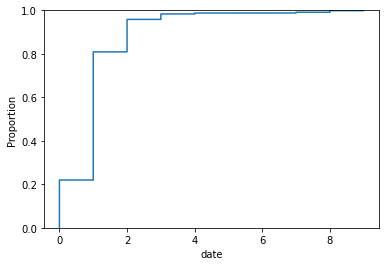

In [20]:
import seaborn as sns
sns.ecdfplot(rest.dropna());

Let's add that result to the `teams` dataframe.

In [23]:
teams['rest'] = rest
teams.dropna()

,game_id,date,home_away,team,rest
4,5,2015-10-28,away_team,Chicago Bulls,0.0
1235,6,2015-10-28,home_team,Detroit Pistons,0.0
8,9,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,15,2015-10-28,away_team,New Orleans Pelicans,0.0
17,18,2015-10-29,away_team,Memphis Grizzlies,0.0
...,...,...,...,...,...
2457,1234,2016-04-13,home_team,Phoenix Suns,1.0
1228,1235,2016-04-13,away_team,Denver Nuggets,2.0
2458,1235,2016-04-13,home_team,Portland Trail Blazers,3.0
1229,1236,2016-04-13,away_team,Atlanta Hawks,1.0


## Invert the melt

We can use `pandas.pivot_table` to invert the `melt` operation. You describe the output shape you want.

In [24]:
pd.pivot_table(teams, values='rest', index=['game_id', 'date'], columns='home_away')

,home_away,away_team,home_team
game_id,date,,
5,2015-10-28,0.0,NaN
6,2015-10-28,NaN,0.0
9,2015-10-28,0.0,NaN
15,2015-10-28,0.0,NaN
18,2015-10-29,0.0,0.0
...,...,...,...
1232,2016-04-13,0.0,1.0
1233,2016-04-13,1.0,1.0
1234,2016-04-13,0.0,1.0


In [26]:
by_game = (pd.pivot_table(teams, values='rest',
                          index=['game_id', 'date'],
                          columns='home_away')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'})
             .rename_axis(None, axis='columns'))
by_game.dropna().head()

,,away_rest,home_rest
game_id,date,,
18,2015-10-29,0.0,0.0
19,2015-10-29,0.0,0.0
20,2015-10-29,1.0,0.0
21,2015-10-30,1.0,0.0
22,2015-10-30,1.0,1.0


In [28]:
games_rest = pd.concat([games, by_game], axis='columns').dropna()
games_rest

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
18,2015-10-29,Memphis Grizzlies,112.0,Indiana Pacers,103.0,0.0,0.0
19,2015-10-29,Dallas Mavericks,88.0,Los Angeles Clippers,104.0,0.0,0.0
20,2015-10-29,Atlanta Hawks,112.0,New York Knicks,101.0,1.0,0.0
21,2015-10-30,Charlotte Hornets,94.0,Atlanta Hawks,97.0,1.0,0.0
22,2015-10-30,Toronto Raptors,113.0,Boston Celtics,103.0,1.0,1.0
...,...,...,...,...,...,...,...
1232,2016-04-13,Indiana Pacers,97.0,Milwaukee Bucks,92.0,0.0,1.0
1233,2016-04-13,New Orleans Pelicans,109.0,Minnesota Timberwolves,144.0,1.0,1.0
1234,2016-04-13,Los Angeles Clippers,105.0,Phoenix Suns,114.0,0.0,1.0


So now we have two datasets, either of which might be "tidy" *depending on the question*.

When we're asking *team*-level questions (e.g. does the average days of rest vary over the course of the season?) we'd use `teams`. When we're asking *game*-level questions then we'd use `games_rest`.

## Exercise

Does the home team tend to win more often when they're more rested than the away team? Does this question need data on *games* or *teams*?

There's several ways to get at this question. My solution breaks it into three steps:

1. Create a boolean series indicating whether the home team had more rest than the away team
2. Create a boolean series indicating whether the home team won (more points)
3. Group the "home team won" series by the "home team had more rest" series and take the mean. Note: *you can group by an array*, not just a column name.

In [33]:
# 1. Did the home team have more rest?
home_more_rested = games_rest['home_rest'] > games_rest['away_rest']
home_more_rested

game_id  date      
18       2015-10-29    False
19       2015-10-29    False
20       2015-10-29    False
21       2015-10-30    False
22       2015-10-30    False
                       ...  
1232     2016-04-13     True
1233     2016-04-13    False
1234     2016-04-13     True
1235     2016-04-13     True
1236     2016-04-13    False
Length: 1213, dtype: bool

In [34]:
# 2. Did the home team win?
home_won = games_rest['home_points'] > games_rest['away_points']
home_won

game_id  date      
18       2015-10-29    False
19       2015-10-29     True
20       2015-10-29    False
21       2015-10-30     True
22       2015-10-30    False
                       ...  
1232     2016-04-13    False
1233     2016-04-13     True
1234     2016-04-13     True
1235     2016-04-13     True
1236     2016-04-13     True
Length: 1213, dtype: bool

In [36]:
# 3. Group and take the mean
home_won.groupby(home_more_rested).mean()

False    0.580324
True     0.609756
dtype: float64

In [ ]:
# %load solutions/tidy_rest_advantage.py
home_more_rested = games_rest['home_rest'] > games_rest['away_rest']
home_won = games_rest['home_points'] > games_rest['away_points']
home_won.groupby(home_more_rested).mean()


## Next Steps

Next, we'll move to [Performance](Performance.ipynb).